# Spy Machine Learning Models -- Intraday

In [1]:
from sklearn.preprocessing import MinMaxScaler
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import numpy as np
import plotly.graph_objects as go
import yfinance as yf
import pandas_ta as ta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRegressor

In [2]:
spy_1 = yf.download(
        tickers = "SPY",
        period = "1mo",
        interval = "5m",
        group_by = 'column',
        auto_adjust = False,
        prepost = False,
        threads = True,
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


In [3]:
spy_1.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']

In [4]:
spy_1.drop(columns='adj close', inplace=True)

In [5]:
spy = yf.download(
        tickers = "SPY",
        period = "1mo",
        interval = "5m",
        group_by = 'column',
        auto_adjust = False,
        prepost = False,
        threads = True,
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


In [6]:
NonMPStrategy = ta.Strategy(
    name="EMAs, BBs, and MACD",
    description=" Strategy by rename Columns",
    ta=[
        {"kind": "ema", "length": 8},
        {"kind": "ema", "length": 21},
        {"kind": "rsi", "col_names": 'RSI' },
        {"kind": "bbands", "length": 20, "col_names": ("BBL", "BBM", "BBU")},
        {"kind": "macd", "fast": 8, "slow": 21, "col_names": ("MACD", "MACD_H", "MACD_S")}
    ]
)
# Run it
spy.ta.strategy(NonMPStrategy)

In [7]:
spy_intra = spy

In [8]:
spy_intra.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1716 entries, 2021-01-27 09:30:00-05:00 to 2021-02-26 15:55:00-05:00
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1716 non-null   float64
 1   high       1716 non-null   float64
 2   low        1716 non-null   float64
 3   close      1716 non-null   float64
 4   adj_close  1716 non-null   float64
 5   volume     1716 non-null   int64  
 6   EMA_8      1709 non-null   float64
 7   EMA_21     1696 non-null   float64
 8   RSI_14     1715 non-null   float64
 9   BBL        1697 non-null   float64
 10  BBM        1697 non-null   float64
 11  BBU        1697 non-null   float64
 12  MACD       1696 non-null   float64
 13  MACD_H     1696 non-null   float64
 14  MACD_S     1708 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 214.5 KB


In [9]:
spy_intra.dropna()

,open,high,low,close,adj_close,volume,EMA_8,EMA_21,RSI_14,BBL,BBM,BBU,MACD,MACD_H,MACD_S
datetime,,,,,,,,,,,,,,,
2021-01-27 11:10:00-05:00,378.970001,379.049988,378.579987,378.670013,378.670013,435329,379.104549,378.532138,49.084605,376.409214,378.539244,380.669274,0.572411,0.146382,0.426029
2021-01-27 11:15:00-05:00,378.670013,378.679993,377.959991,378.154999,378.154999,620911,378.893538,378.497853,42.965612,376.415154,378.542494,380.669835,0.395686,-0.024275,0.419960
2021-01-27 11:20:00-05:00,378.149994,378.459991,377.940002,378.320007,378.320007,608791,378.766087,378.481685,45.317697,376.741671,378.635495,380.529319,0.284402,-0.108447,0.392849
2021-01-27 11:25:00-05:00,378.321014,378.480011,378.059998,378.179993,378.179993,1310201,378.635844,378.454258,43.671923,377.185055,378.731995,380.278934,0.181585,-0.169011,0.350596
2021-01-27 11:30:00-05:00,378.200012,378.350006,377.420013,377.480011,377.480011,1300955,378.378992,378.365690,36.529522,377.462103,378.777495,380.092887,0.013302,-0.269835,0.283137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26 15:35:00-05:00,382.519989,382.750000,382.220001,382.515015,382.515015,1432683,382.951525,382.973314,45.600523,380.960362,382.669247,384.378133,-0.021789,-0.087389,0.065600
2021-02-26 15:40:00-05:00,382.510010,383.540009,382.299988,383.250000,383.250000,1805536,383.017853,382.998467,52.096336,381.055572,382.738748,384.421924,0.019386,-0.036972,0.056358
2021-02-26 15:45:00-05:00,383.250000,384.809998,383.250000,384.600006,384.600006,2108057,383.369442,383.144062,61.249272,381.033523,382.869499,384.705475,0.225381,0.135219,0.090162


In [10]:
spy_intra['volume'] = spy_intra['volume'].astype('float64')

In [11]:
spy_intra.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1716 entries, 2021-01-27 09:30:00-05:00 to 2021-02-26 15:55:00-05:00
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1716 non-null   float64
 1   high       1716 non-null   float64
 2   low        1716 non-null   float64
 3   close      1716 non-null   float64
 4   adj_close  1716 non-null   float64
 5   volume     1716 non-null   float64
 6   EMA_8      1709 non-null   float64
 7   EMA_21     1696 non-null   float64
 8   RSI_14     1715 non-null   float64
 9   BBL        1697 non-null   float64
 10  BBM        1697 non-null   float64
 11  BBU        1697 non-null   float64
 12  MACD       1696 non-null   float64
 13  MACD_H     1696 non-null   float64
 14  MACD_S     1708 non-null   float64
dtypes: float64(15)
memory usage: 214.5 KB


In [12]:
spy_intra.drop(columns= 'adj_close', inplace=True)

In [13]:
spy_intra = spy_intra[np.isfinite(spy_intra).all(1)]
spy_intra

,open,high,low,close,volume,EMA_8,EMA_21,RSI_14,BBL,BBM,BBU,MACD,MACD_H,MACD_S
datetime,,,,,,,,,,,,,,
2021-01-27 11:10:00-05:00,378.970001,379.049988,378.579987,378.670013,435329.0,379.104549,378.532138,49.084605,376.409214,378.539244,380.669274,0.572411,0.146382,0.426029
2021-01-27 11:15:00-05:00,378.670013,378.679993,377.959991,378.154999,620911.0,378.893538,378.497853,42.965612,376.415154,378.542494,380.669835,0.395686,-0.024275,0.419960
2021-01-27 11:20:00-05:00,378.149994,378.459991,377.940002,378.320007,608791.0,378.766087,378.481685,45.317697,376.741671,378.635495,380.529319,0.284402,-0.108447,0.392849
2021-01-27 11:25:00-05:00,378.321014,378.480011,378.059998,378.179993,1310201.0,378.635844,378.454258,43.671923,377.185055,378.731995,380.278934,0.181585,-0.169011,0.350596
2021-01-27 11:30:00-05:00,378.200012,378.350006,377.420013,377.480011,1300955.0,378.378992,378.365690,36.529522,377.462103,378.777495,380.092887,0.013302,-0.269835,0.283137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26 15:35:00-05:00,382.519989,382.750000,382.220001,382.515015,1432683.0,382.951525,382.973314,45.600523,380.960362,382.669247,384.378133,-0.021789,-0.087389,0.065600
2021-02-26 15:40:00-05:00,382.510010,383.540009,382.299988,383.250000,1805536.0,383.017853,382.998467,52.096336,381.055572,382.738748,384.421924,0.019386,-0.036972,0.056358
2021-02-26 15:45:00-05:00,383.250000,384.809998,383.250000,384.600006,2108057.0,383.369442,383.144062,61.249272,381.033523,382.869499,384.705475,0.225381,0.135219,0.090162


In [14]:
def feature_imp(data):
    corrmat=data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(10,10))
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),annot=True,)
    plt.title('Correlation between different fearures and target')
    plt.show()
    return

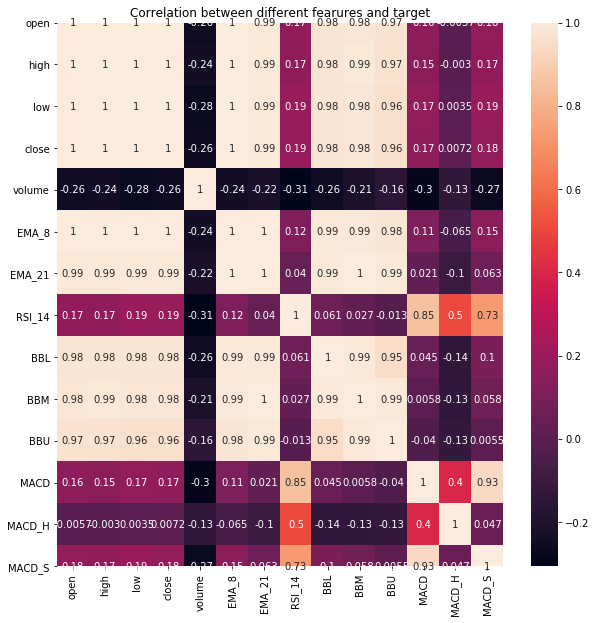

In [15]:
feature_imp(spy_intra)

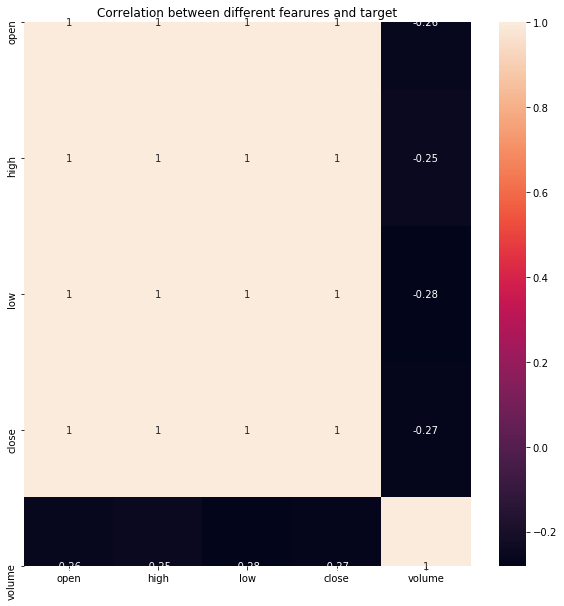

In [16]:
feature_imp(spy_1)

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [18]:
def modeling(data):
    X = data.drop(['close'], axis=1)
    Y=data['close']
    x_Train, x_Test, y_Train, y_Test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
    models = []

    models.append(('KNN' , KNeighborsRegressor()))
    models.append(('NB' , GaussianProcessRegressor()))
    models.append(('SVM' , SVR()))
    models.append(('RF' , RandomForestRegressor(n_estimators=60, max_depth=2, bootstrap=False, min_samples_leaf=1)))
    models.append(('XGBoost', XGBClassifier(gamma=0.0, n_estimators=60,
                                           base_score=0.7,
                                           max_depth=3, 
                                           objective = "binary:logistic", 
                                           colsample_bytree=1,
                                           learning_rate=0.01)))
    
    results = []
    names = []

    for name, model in models:
        clf = model
        clf.fit(x_Train, y_Train)
        y_pred = clf.predict(x_Test)
        rmes = np.sqrt(mean_squared_error(y_Test, y_pred))
        results.append([name, rmes])
        #print(name + ": " + str(accu_score))
    
    re=pd.DataFrame(results, columns=['Model', 'RMSE'])
    re.set_index(['Model'])
    return re

In [19]:
modeling(spy_1)

,Model,RMSE
0,KNN,6.131571
1,NB,385.735972
2,SVM,5.813167
3,RF,1.625753
4,XGBoost,3.608739


In [20]:
modeling(spy_intra)

,Model,RMSE
0,KNN,5.806012
1,NB,385.961968
2,SVM,5.657888
3,RF,1.562405
4,XGBoost,3.438926


In [21]:
# Feature Importances

In [22]:
def feature_importance(data):
    X = data.drop(['close'], axis=1)
    Y = data['close']
    x_Train, x_Test, y_Train, y_Test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
    
    clf1 = RandomForestRegressor(n_estimators=60)
    clf1.fit(x_Train, y_Train)
    y_pred = clf1.predict(x_Test)
    rmes = np.sqrt(mean_squared_error(y_Test, y_pred))
    
    importances = clf1.feature_importances_
    features = x_Train.columns
    indices = np.argsort(importances)
    
    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    
    print(rmes)
    return

0.2771395730084264


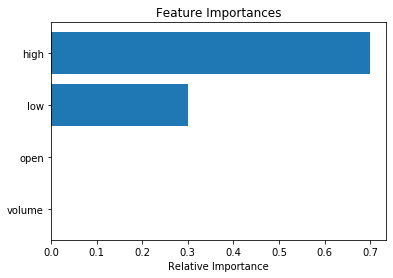

In [23]:
feature_importance(spy_1)

In [24]:
def feature_importance_TI(data):
    X = data.drop(['close', 'high', 'low', 'open'], axis=1)
    Y = data['close']
    x_Train, x_Test, y_Train, y_Test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
    
    clf1 = RandomForestRegressor(n_estimators=60)
    clf1.fit(x_Train, y_Train)
    y_pred = clf1.predict(x_Test)
    rmes = np.sqrt(mean_squared_error(y_Test, y_pred))
    
    importances = clf1.feature_importances_
    features = x_Train.columns
    indices = np.argsort(importances)
    
    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    
    print(rmes)
    return

0.33978385102024483


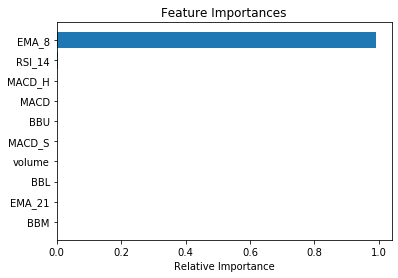

In [25]:
feature_importance_TI(spy_intra)